Readme
=======

Requirements : 
1. AWS Subscription - for using SageMaker and its associated services  
2. AIShield subscription details - URL and subscription key for for making call to image classification service for vulnerability analysis
3. Training script and its requirements file (for required library installation) is already present inside code folder. The code folder can be copied the current working directory and its path need to be specified accordingly in the reference notebook.

Steps : 
1. Create a SageMaker notebook with configuration as - Python 3 (Tensorflow 2.3 Python 3.7). 'CPU optimized' configuration should solve the purpose if its not compute heavy. 
2. Import and open the provided notebook and code folder to the environment.
3. Follow the steps as mentioned in the notebook.
4. Variable/parameter values need to be changed as per run configuration.


In [1]:
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd
import time
import random
import cv2
import gzip
import zipfile
import shutil
import tarfile
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import datasets

import sagemaker
from sagemaker.tensorflow import TensorFlow, TensorFlowModel
from sagemaker import get_execution_role

import warnings
warnings.filterwarnings("ignore")

In [3]:
sess = sagemaker.Session()
role = get_execution_role()

In [4]:
output_path = "s3://" + sess.default_bucket() + "/tensorflow/mnist"
print(output_path)

s3://sagemaker-eu-central-1-901214976877/tensorflow/mnist


### Data

In [5]:
import logging
import boto3
from botocore.exceptions import ClientError

# Download training and testing data from a public S3 bucket
def download_from_s3(data_dir="/tmp/data", train=True):
    """Download MNIST dataset and convert it to numpy array

    Args:
        data_dir (str): directory to save the data
        train (bool): download training set

    Returns:
        None
    """

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if train:
        images_file = "train-images-idx3-ubyte.gz"
        labels_file = "train-labels-idx1-ubyte.gz"
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        labels_file = "t10k-labels-idx1-ubyte.gz"

    # download objects
    s3 = boto3.client("s3")
    bucket = f"sagemaker-sample-files"
    for obj in [images_file, labels_file]:
        key = os.path.join("datasets/image/MNIST", obj)
        dest = os.path.join(data_dir, obj)
        if not os.path.exists(dest):
            s3.download_file(bucket, key, dest)
    return


download_from_s3("/tmp/data", True)
download_from_s3("/tmp/data", False)

In [6]:
# upload to the default S3 bucket

prefix = "mnist"
bucket = sess.default_bucket()
loc = sess.upload_data(path="/tmp/data", bucket=bucket, key_prefix=prefix)

channels = {"training": loc, "testing": loc}

### Modelling

In [7]:
!pygmentize 'code/train.py'

from __future__ import print_function

import argparse
import gzip
import json
import logging
import os
import traceback

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten

logging.basicConfig(level=logging.DEBUG)

# Define the model object


class SmallConv(Model):
    def __init__(self):
        super(SmallConv, self).__init__()
        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation="relu")
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


# Decode and preprocess data
def convert_to_numpy(data_dir, images_file, labels_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzi

In [8]:
instance_type = "ml.c4.xlarge"

est = TensorFlow(
    entry_point="train.py",
    source_dir="code",  # directory of your training script
    role=role,
    framework_version="2.3.1",
    model_dir=False,  # don't pass --model_dir to your training script
    py_version="py37",
    instance_type=instance_type,
    instance_count=1,
    volume_size=5,
    output_path=output_path,
    hyperparameters={
        "batch-size": 512,
        "epochs": 1,
        "learning-rate": 1e-3,
        "beta_1": 0.9,
        "beta_2": 0.999,
    },
)

### Training

In [9]:
est.fit(inputs=channels)

2022-04-25 13:47:41 Starting - Starting the training job...
2022-04-25 13:48:06 Starting - Preparing the instances for trainingProfilerReport-1650894460: InProgress
......
2022-04-25 13:49:10 Downloading - Downloading input data...
2022-04-25 13:49:26 Training - Downloading the training image.....2022-04-25 13:50:24.721553: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-04-25 13:50:24.731055: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-04-25 13:50:25.090232: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.

2022-04-25 13:50:26 Training - Training image download completed. Training in progress.2022-04-25 13:50:28,843 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-04-25 13:50:28,85

In [10]:
tf_mnist_model_data = est.model_data
print("Model artifact saved at:\n", tf_mnist_model_data)

Model artifact saved at:
 s3://sagemaker-eu-central-1-901214976877/tensorflow/mnist/tensorflow-training-2022-04-25-13-47-40-595/output/model.tar.gz


# AIShield Model Vulnerability Check

### 1. Prepare Data , Model and Label

> Expected Data Format - all image files in a folder

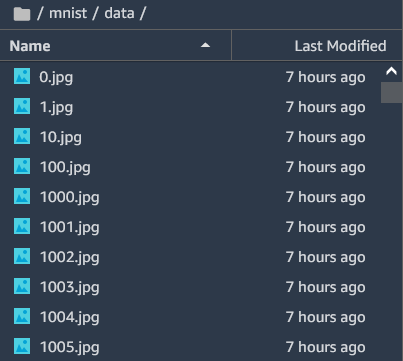

> Expected Label Format - csv file mapping filename to label

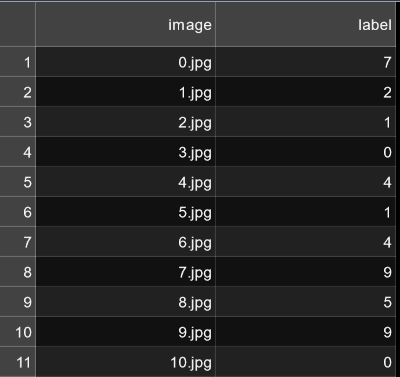

##### Download the model  to local

In [11]:
s3 = boto3.client("s3")
bucket = sess.default_bucket()

In [12]:
model_key = "tensorflow/mnist/tensorflow-training-2022-04-25-06-28-59-613/output/model.tar.gz"
data_key = "mnist/t10k-images-idx3-ubyte.gz"
label_key = "mnist/t10k-labels-idx1-ubyte.gz"

In [13]:
# model
s3.download_file(bucket, model_key, "model.tar.gz")
# data
s3.download_file(bucket, data_key, "t10k-images-idx3-ubyte.gz")
# label
s3.download_file(bucket, label_key, "t10k-labels-idx1-ubyte.gz")

In [14]:
shutil.unpack_archive('model.tar.gz', 'model')

In [15]:
data_dir="/tmp/data"
images_file = "t10k-images-idx3-ubyte.gz"
labels_file = "t10k-labels-idx1-ubyte.gz"

with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

with gzip.open(os.path.join(data_dir, labels_file), "rb") as f:
    labels = np.frombuffer(f.read(), np.uint8, offset=8)

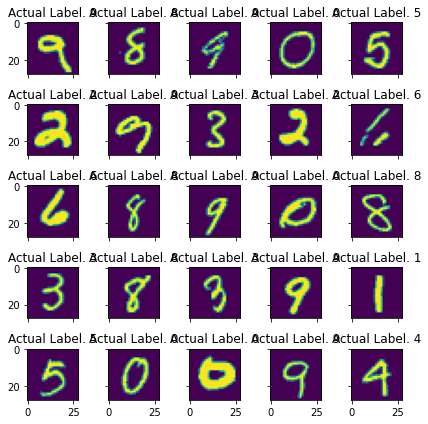

In [21]:
'''
Description: Visualize few random data sample
'''
rows=5

random_indices=random.sample(range(images.shape[0]),rows*rows)
sample_images=images[random_indices,:]
sample_images = np.expand_dims(sample_images, axis=-1) 
sample_labels=labels[random_indices]

fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(6,6),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("Actual Label. %d" % sample_labels[i])
plt.tight_layout()

#### Save data, label and model in zip 

In [17]:
%%time
"""
Description: Save data and label
"""
label=pd.DataFrame()
img_name = []
img_label = [] 

if not os.path.isdir("data"):
    os. makedirs("data")
    
for i in range(images.shape[0]):
    cv2.imwrite(os.path.join("data",str(i)+".jpg") ,images[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
    img_name.append(str(i)+".jpg")
    img_label.append(labels[i])
label['image'] = img_name
label["label"] = np.array(img_label)

#write orig_label dataframe
label.to_csv(os.path.join("label.csv"),index=False)

CPU times: user 1.93 s, sys: 1.28 s, total: 3.21 s
Wall time: 2min 27s


In [18]:
"""
Description: Zip data
"""
def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))
      
zipf = zipfile.ZipFile('data.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('data', zipf)
zipf.close()

In [19]:
"""
Description: Zip label
"""
zipfile.ZipFile('label.zip', mode='w').write("label.csv")

In [20]:
"""
Description: Zip model
"""
shutil.make_archive(base_name='model', format='zip', root_dir='model')

'/root/mnist/model.zip'

### 2. AIShield API Call¶

In [22]:
"""
Description: AIShield API URL and subscription key
""" 
url="https://apim-prod-ais-01.azure-api.net/trial/ic/ais/ImageClassification/VulnerabiltyReport"
headers={'Cache-Control': 'no-cache',
'Ocp-Apim-Subscription-Key': "5df172bfa36b444dbb4984c8b6cf302f"
}

In [23]:
"""
Description: Payload for AIShield VulnerabilityReport api call
"""
payload={}
payload['input_dimensions']=str((28,28,1))
payload['number_of_classes']=str(10)
payload['attack_type']="Blackbox"
payload['number_of_attack_queries']=50000
payload['model_framework']='Tensorflow'
payload['vulnerability_threshold']="0"
payload['normalize_data']="yes"
payload['defense_bestonly']="no"
payload['encryption_strategy']=0

In [24]:
"""
Description: Files path
"""
cur_dir=os.getcwd()
data_path=os.path.join(cur_dir,'data.zip') #full path of data zip
label_path=os.path.join(cur_dir,'label.zip') #full path of label zip
model_path=os.path.join(cur_dir,'model.zip') #full path of model zip

In [25]:
"""
Description: Files for AIShield VulnerabilityReport api call
"""
model_name=os.path.split(model_path)[1] #model file name
data_name=os.path.split(data_path)[1] #data file name
label_name=os.path.split(label_path)[1] #label file name

files=[
  ('data_zip',(data_name,open(data_path,'rb'),'application/x-zip-compressed')),
  ('model_zip',(model_name,open(model_path,'rb'),'application/x-zip-compressed')),
  ('label_zip',(label_name,open(label_path,'rb'),'application/x-zip-compressed'))
  ]

In [26]:
"""
Description: Hit AIShield VulnerabilityReport api
"""
new_request = requests.request(method="POST", url=url, params=payload, files=files,headers=headers)
new_request=json.loads(new_request.text)
for k, v in new_request.items():
    print("* {} : {}".format(k,v))

* attack_type : Blackbox
* defense_bestonly : no
* encryption_strategy : 0
* input_dimensions : (28, 28, 1)
* job_id : gAAAAABiZrEpe5p30jQ8ZvhHvsWDND5dtGTFmy9qJu397GssvPV99bk4YMZ4NyQTAfqYe_09Z9KkYTlfZ24432k_0-RYkYOeWQ==
* model_framework : Tensorflow
* monitor_link : FEATURE NOT AVAILABLE
* normalize_data : yes
* number_of_attack_queries : 50000
* number_of_classes : 10
* vulnerability_threshold : 0.0


In [27]:
"""
Description: Get job id from api response
"""
job_id=new_request['job_id']
print(f"Job id : {job_id}")

Job id : gAAAAABiZrEpe5p30jQ8ZvhHvsWDND5dtGTFmy9qJu397GssvPV99bk4YMZ4NyQTAfqYe_09Z9KkYTlfZ24432k_0-RYkYOeWQ==


In [28]:
"""
Description: Query GetProcessDetail api and Monitor progress for job id
"""
job_status_url=url[:-18]+"JobStatusDetailed?JobID=" +job_id

#status dictionary
status_dictionary={
 'ModelExploration_Status': 'na',
 'SanityCheck_Status': 'na',
 'QueryGenerator_Status': 'na',
 'VunerabilityEngine_Status': 'na', 
 'DefenseReport_Status': 'na',
 'IntegratedModelGenerator_Status':'na',

}
while(True):
    time.sleep(5) 
    job_status_response = requests.request("GET", job_status_url, params={},headers=headers)

    job_status_payload=json.loads(job_status_response.text)
    failing_key='ModelExploration_Status'
    for key in status_dictionary.keys():
        if status_dictionary[key]=='na':
            if job_status_payload[key]=='completed' or job_status_payload[key]=='passed':
                status_dictionary[key]=job_status_payload[key]
                print(str(key), ":",status_dictionary[key])
            elif job_status_payload[key]=='failed':
                failing_key=key
                status_dictionary[key]=job_status_payload[key]
                print(str(key), ":",status_dictionary[key])

    if status_dictionary[failing_key]=='failed':
        break

    if status_dictionary['VunerabilityEngine_Status']=='passed' or status_dictionary['VunerabilityEngine_Status']=='completed' and job_status_payload['CurrentStatus']=="Defense generation is not triggered" :
        print("\n Vulnerability score {} failed to cross vulnerability threshoold of {}".format(job_status_payload['VulnerabiltyScore'],job_meta_data['vulnerability_threshold']))
        break
    if job_status_payload['IntegratedModelGenerator_Status']=='completed':
        break

ModelExploration_Status : completed
SanityCheck_Status : passed
QueryGenerator_Status : completed
VunerabilityEngine_Status : completed
DefenseReport_Status : completed
IntegratedModelGenerator_Status : completed


#### Get all Vulnerability and upload to S3

In [ ]:
job_artifact_url=url[:-18]+"GetReport?JobID=" +job_id+"&ReportType=Vulnerability&fileFormat=2"

In [ ]:
job_status_response = requests.request("GET", job_artifact_url, params={},headers=headers)

In [ ]:
with open('/root/mnist/reports/Vulnerability.pdf', 'wb') as f:
    f.write(job_status_response.content)

In [ ]:
# upload the defense model to S3 bucket
prefix = "mnist-ais-reports"
bucket = sess.default_bucket()
vul_report_loc = sess.upload_data(path="/root/mnist/reports/Vulnerability.pdf", bucket=bucket, key_prefix=prefix)
print("Vulnerability report saved at:\n", vul_report_loc)

#### Get defence model artifacts

In [30]:
job_artifact_url=url[:-18]+"GetReport?JobID=" +job_id+"&ReportType=Defense_artifact&fileFormat=0"

In [31]:
job_status_response = requests.request("GET", job_artifact_url, params={},headers=headers)

In [32]:
with open('defense_artifact.zip', "wb") as f:
  f.write(job_status_response.content)

shutil.unpack_archive('defense_artifact.zip', 'defense_artifact')

### 3. Converting to SageMaker compatible - TensorFlow ProtoBuf format for deployment

In [34]:
loaded_defense_model = keras.models.load_model('/root/mnist/defense_artifact/defense_model.h5')

[2022-04-25 14:43:04.767 tensorflow-2-3-cpu-py-ml-t3-medium-f34868a61417544349a28b60e5e0:455 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-25 14:43:05.015 tensorflow-2-3-cpu-py-ml-t3-medium-f34868a61417544349a28b60e5e0:455 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [35]:
model_version = '3'
export_dir = '/root/mnist/defense_artifact/Servo/' + model_version
tf.saved_model.save(loaded_defense_model, export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /root/mnist/defense_artifact/Servo/3/assets


INFO:tensorflow:Assets written to: /root/mnist/defense_artifact/Servo/3/assets


In [36]:
import tarfile
with tarfile.open('/root/mnist/defense_artifact/model.tar.gz', mode='w:gz') as archive:
    archive.add(export_dir, recursive=True)

In [37]:
# upload the defense model to S3 bucket
prefix = "mnist-defense"
bucket = sess.default_bucket()
defense_model_loc = sess.upload_data(path="/root/mnist/defense_artifact/model.tar.gz", bucket=bucket, key_prefix=prefix)
print("Defense model artifact saved at:\n", defense_model_loc)

Defense model artifact saved at:
 s3://sagemaker-eu-central-1-901214976877/mnist-defense/model.tar.gz


# Deploy

In [38]:
test_data = np.random.rand(2, 28, 28, 1)

#### 1. Deploy original model

In [39]:
tf_mnist_model_data = est.model_data
print("Model artifact saved at:\n", tf_mnist_model_data)

Model artifact saved at:
 s3://sagemaker-eu-central-1-901214976877/tensorflow/mnist/tensorflow-training-2022-04-25-13-47-40-595/output/model.tar.gz


In [40]:
predictor = est.deploy(initial_instance_count=1, instance_type="ml.c4.large")
print('predictor endpoint: ', predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: tensorflow-training-2022-04-25-14-43-14-938
INFO:sagemaker:Creating endpoint with name tensorflow-training-2022-04-25-14-43-14-938


-----!

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


predictor endpoint:  tensorflow-training-2022-04-25-14-43-14-938


In [41]:
# sanity check
prediction = np.argmax(predictor.predict(test_data)['predictions'], axis=1)
print(prediction)

[5 5]


#### 2. Deploy defence model

In [42]:
defense_model_loc

's3://sagemaker-eu-central-1-901214976877/mnist-defense/model.tar.gz'

In [43]:
defense_model = TensorFlowModel(model_data=defense_model_loc, role=role, framework_version="2.3.1",)

In [44]:
defense_predictor = defense_model.deploy(initial_instance_count=1, instance_type="ml.c4.large")
print('Defense predictor endpoint: ', defense_predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: tensorflow-inference-2022-04-25-15-04-54-107
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2022-04-25-15-04-54-446


-----!

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Defense predictor endpoint:  tensorflow-inference-2022-04-25-15-04-54-446


In [45]:
# sanity check
np.argmax(defense_predictor.predict(test_data)['predictions'], axis=1)

array([1, 1])

# Harden original model

In [46]:
def pred_without_ais(data):
    prediction = np.argmax(predictor.predict(data)['predictions'], axis=1)
    return prediction

In [47]:
def pred_with_ais(data):
    # passing to AIS-defense model
    defense_prediction =  np.argmax(defense_predictor.predict(data)['predictions'], axis=1)
    # passing to actual model
    orig_prediction = np.argmax(predictor.predict(data)['predictions'], axis=1)
    # Manipulating actual prediction based on defense model prediction
    prediction = ['Attack' if def_pred==1 else orig_prediction[idx] for idx, def_pred in enumerate(defense_prediction)]
    return prediction

# Results

#### 1. Actual data

In [48]:
'''
Description: Visualize few random data sample
'''
rows=5

random_indices=random.sample(range(images.shape[0]),rows*rows)
sample_images=images[random_indices,:]
sample_images = np.expand_dims(sample_images, axis=-1) 
sample_labels=labels[random_indices]

In [49]:
pred_wo_ais = pred_without_ais(sample_images)
pred_wo_ais

array([7, 2, 5, 7, 3, 9, 1, 1, 5, 1, 2, 2, 6, 3, 7, 0, 8, 1, 6, 2, 8, 9,
       3, 5, 9])

In [50]:
# prediction with AIS integrationa
pred_w_ais = pred_with_ais(sample_images)
pred_w_ais

[7, 2, 5, 7, 3, 9, 1, 1, 5, 1, 2, 2, 6, 3, 7, 0, 8, 1, 6, 2, 8, 9, 3, 5, 9]

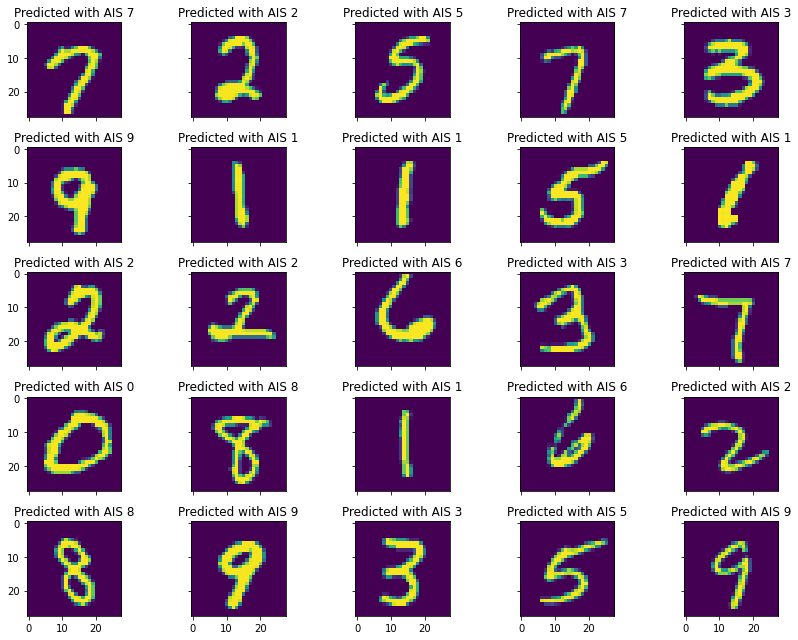

In [51]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted with AIS %d" % pred_w_ais[i])
plt.tight_layout()

### 2. Attack data

In [52]:
'''
Description: Create quereis for model extraction
'''
attack_queries = np.random.rand(25,28,28,1)*0
for i in (range(attack_queries.shape[0])):
    for _ in range(np.random.randint(0,20)):
        x1 = np.random.randint(0,20)
        y1 = np.random.randint(0,20)
        x2 = np.random.randint(x1,28)
        y2 = np.random.randint(y1,28)
        attack_queries[i,x1:x2,y1:y2,0] = 1        

#### 2.1.1 without AIS

In [53]:
# prediction without AIS integrationa
pred_wo_ais = pred_without_ais(attack_queries)
pred_wo_ais

array([5, 5, 2, 3, 5, 5, 2, 7, 2, 7, 5, 6, 5, 3, 5, 6, 2, 4, 2, 6, 2, 5,
       9, 5, 5])

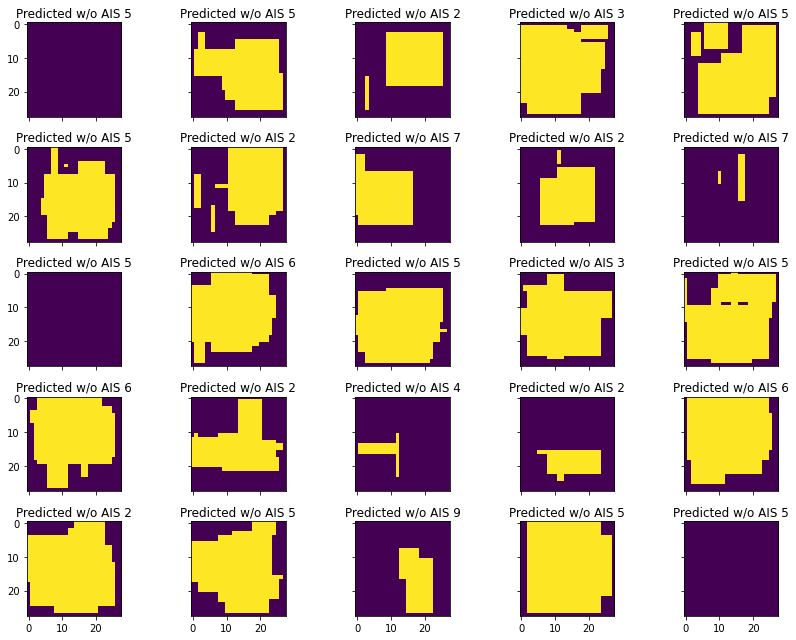

In [54]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(attack_queries[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted w/o AIS %d" % pred_wo_ais[i])
plt.tight_layout()

#### 2.2.2 with AIS

In [55]:
# prediction with AIS integrationa
pred_ais = pred_with_ais(attack_queries)

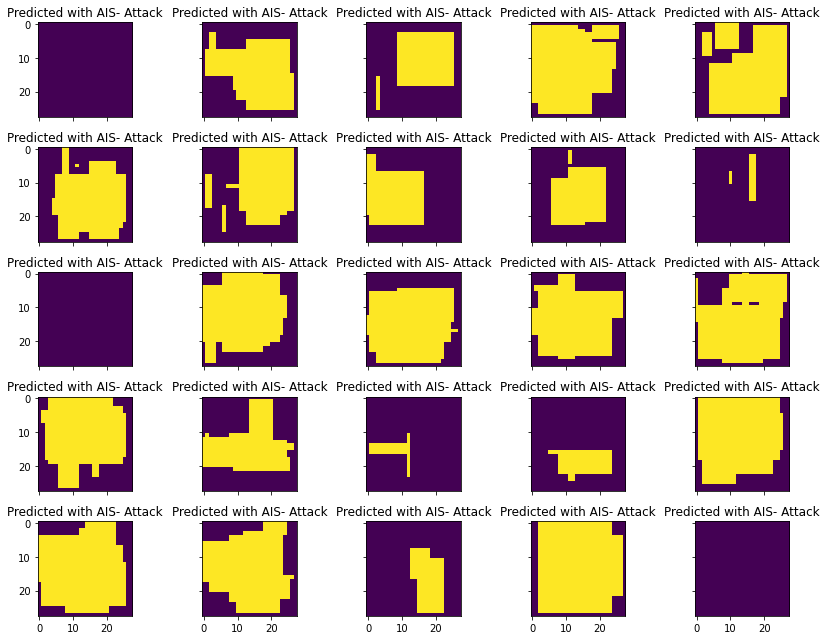

In [56]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(attack_queries[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted with AIS- %s" % str(pred_ais[i]))
plt.tight_layout()

## Clean-up deployments

In [57]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: tensorflow-training-2022-04-25-14-43-14-938
INFO:sagemaker:Deleting endpoint with name: tensorflow-training-2022-04-25-14-43-14-938


In [58]:
defense_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: tensorflow-inference-2022-04-25-15-04-54-446
INFO:sagemaker:Deleting endpoint with name: tensorflow-inference-2022-04-25-15-04-54-446
